# Assistants 

[Assistants](https://langchain-ai.github.io/langgraph/concepts/assistants/#resources) give developers a quick and easy way to modify and version agents for experimentation.

## Supplying configuration to the graph

Our `task_maistro` graph is already set up to use assistants!

It has a `configuration.py` file defined and loaded in the graph.

We access configurable fields (`user_id`, `todo_category`, `task_maistro_role`) inside the graph nodes.

## Creating assistants 

Now, what is a practical use-case for assistants with the `task_maistro` app that we've been building?

For me, it's the ability to have separate ToDo lists for different categories of tasks. 

For example, I want one assistant for my personal tasks and another for my work tasks.

This is very easily configurable using the `todo_category` configurable field.

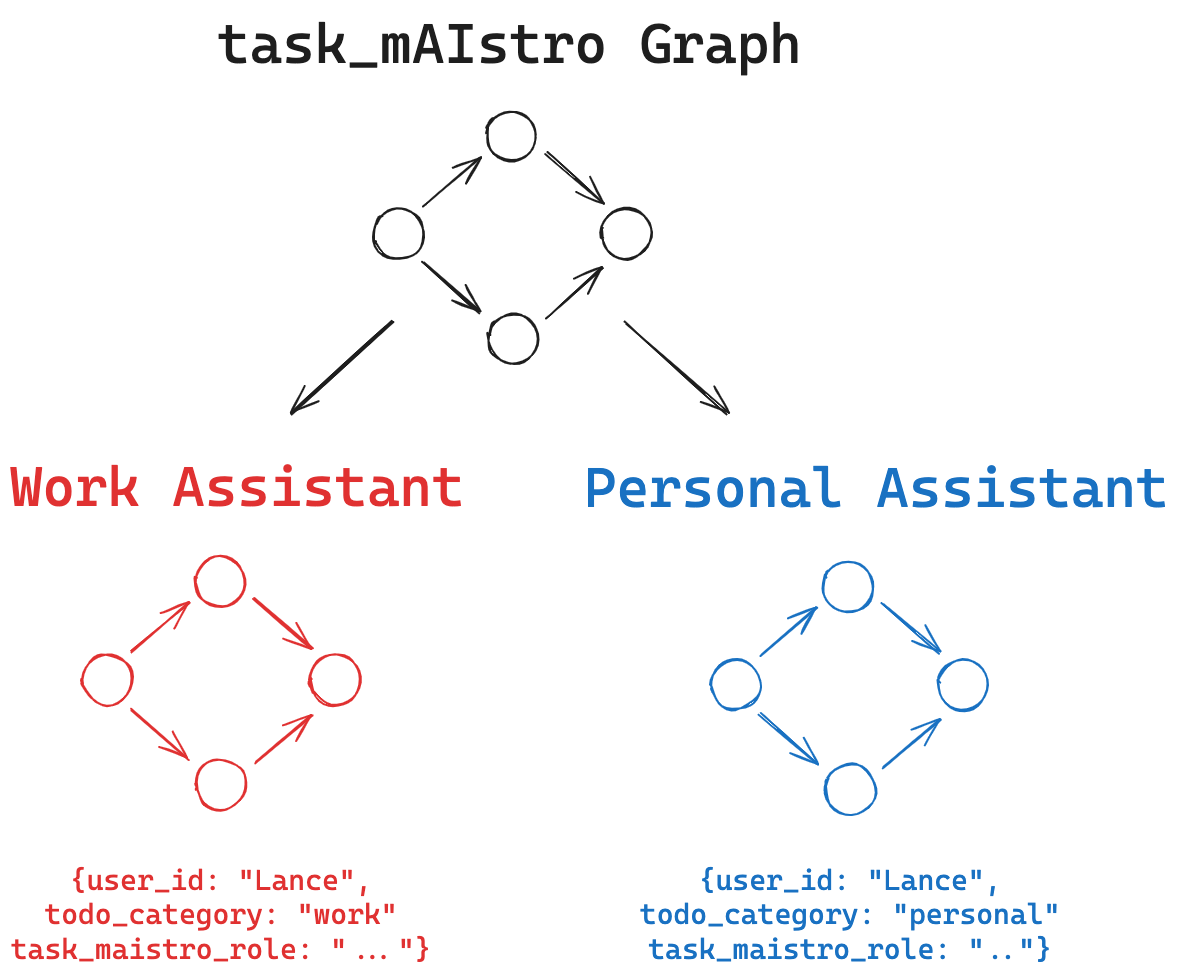

In [ ]:
%%capture --no-stderr
%pip install -U langgraph_sdk

This is the default assistant that we created when we deployed the graph.

In [33]:
from langgraph_sdk import get_client
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)

### Personal assistant

This is the personal assistant that I'll use to manage my personal tasks.

In [34]:
personal_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro", 
    config={"configurable": {"todo_category": "personal"}}
)
print(personal_assistant)

{'assistant_id': '4115c259-2d38-4a23-81db-4397d494ba77', 'graph_id': 'task_maistro', 'created_at': '2024-11-15T04:10:58.419761+00:00', 'updated_at': '2024-11-15T04:10:58.419761+00:00', 'config': {'configurable': {'todo_category': 'personal'}}, 'metadata': {}, 'version': 1, 'name': 'Untitled'}


Let's update this assistant to include my `user_id` for convenience, [creating a new version of it](https://langchain-ai.github.io/langgraph/cloud/how-tos/assistant_versioning/#create-a-new-version-for-your-assistant). 

In [39]:
task_maistro_role = """You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:

- Help track and organize personal tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- Proactively ask for deadlines when new tasks are added without them
- Maintain a supportive tone while helping the user stay accountable
- Help prioritize tasks based on deadlines and importance

Your communication style should be encouraging and helpful, never judgmental. 

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Would you like to add one to help us track it better?"""

configurations = {"todo_category": "personal", 
                  "user_id": "lance",
                  "task_maistro_role": task_maistro_role}

personal_assistant = await client.assistants.update(
    personal_assistant["assistant_id"],
    config={"configurable": configurations}
)
print(personal_assistant)

{'assistant_id': '4115c259-2d38-4a23-81db-4397d494ba77', 'graph_id': 'task_maistro', 'created_at': '2024-11-15T04:11:36.498645+00:00', 'updated_at': '2024-11-15T04:11:36.498645+00:00', 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'personal', 'task_maistro_role': 'You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:\n\n- Help track and organize personal tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- Proactively ask for deadlines when new tasks are added without them\n- Maintain a supportive tone while helping the user stay accountable\n- Help prioritize tasks based on deadlines and importance\n\nYour communication style should be encouraging

### Work assistant

Now, let's create a work assistant. I'll use this for my work tasks.

In [41]:
task_maistro_role = """You are a focused and efficient work task assistant. 

Your main focus is helping users manage their work commitments with realistic timeframes. 

Specifically:

- Help track and organize work tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:
  • Developer Relations features: typically 1 day
  • Course lesson reviews/feedback: typically 2 days
  • Documentation sprints: typically 3 days
- Help prioritize tasks based on deadlines and team dependencies
- Maintain a professional tone while helping the user stay accountable

Your communication style should be supportive but practical. 

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Based on similar tasks, this might take [suggested timeframe]. Would you like to set a deadline with this in mind?"""

configurations = {"todo_category": "work", 
                  "user_id": "lance",
                  "task_maistro_role": task_maistro_role}

work_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro", 
    config={"configurable": configurations}
)
print(work_assistant)

{'assistant_id': '3f2a4428-36b1-4637-9aa3-c77ac2d46040', 'graph_id': 'task_maistro', 'created_at': '2024-11-15T04:15:03.335946+00:00', 'updated_at': '2024-11-15T04:15:03.335946+00:00', 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'work', 'task_maistro_role': 'You are a focused and efficient work task assistant. \n\nYour main focus is helping users manage their work commitments with realistic timeframes. \n\nSpecifically:\n\n- Help track and organize work tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:\n  • Developer Relations features: typically 1 day\n  • Course lesson reviews/feedback: typically 2 days\n  • Documentation sprints: typically 3 day

## Using assistants 

Assistants will be saved to `Postgres` in our deployment.  

This allows us to easily search [search](https://langchain-ai.github.io/langgraph/cloud/how-tos/configuration_cloud/) for assistants with the SDK.

In [42]:
assistants = await client.assistants.search()
for assistant in assistants:
    print({
        'assistant_id': assistant['assistant_id'],
        'version': assistant['version'],
        'config': assistant['config']
    })

{'assistant_id': '3f2a4428-36b1-4637-9aa3-c77ac2d46040', 'version': 1, 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'work', 'task_maistro_role': 'You are a focused and efficient work task assistant. \n\nYour main focus is helping users manage their work commitments with realistic timeframes. \n\nSpecifically:\n\n- Help track and organize work tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:\n  • Developer Relations features: typically 1 day\n  • Course lesson reviews/feedback: typically 2 days\n  • Documentation sprints: typically 3 days\n- Help prioritize tasks based on deadlines and team dependencies\n- Maintain a professional tone while helping 

We can manage them easily with the SDK. For example, we can delete assistants that we're no longer using.

In [13]:
await client.assistants.delete('assistant_id')

Let's set the assistant IDs for the `personal` and `work` assistants that I'll work with.

In [43]:
work_assistant_id = '3f2a4428-36b1-4637-9aa3-c77ac2d46040'
personal_assistant_id = '4115c259-2d38-4a23-81db-4397d494ba77'

We can run them. Let's add some ToDos for my work assistant.

In [44]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import convert_to_messages

user_input = "Create a few ToDo items: 1) Re-film Module 6, lesson 5 by end of day tomorrow. 2) Update audioUX repo by mid next week."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create a few ToDo items: 1) Re-film Module 6, lesson 5 by end of day tomorrow. 2) Update audioUX repo by mid next week.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_CsP4c58DSSW8y0zHIg3M2qns)
 Call ID: call_CsP4c58DSSW8y0zHIg3M2qns
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Re-film Module 6, lesson 5', 'deadline': '2024-11-16T23:59:59', 'time_to_complete': 120, 'solutions': ['Set up camera and lighting equipment', 'Review script and lesson plan', 'Ensure quiet environment for filming', 'Charge camera batteries'], 'status': 'not started'}

New ToDo created:
Content: {'task': 'Update audioUX repo', 'deadline': '2024-11-22T23:59:59', 'time_to_complete': 180, 'solutions': ['Review current issues and pull requests', 'Update documentation',

In [45]:
user_input = "Create another ToDo: Create a cron for the FF-take-bot deployment and get this ready to share."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create another ToDo: Create a cron for the FF-take-bot deployment and get this ready to share.
================================== Ai Message ==================================

To help manage this new task effectively, could you provide a deadline for it? Based on similar tasks, setting up a cron job and preparing it for sharing might typically take about 1 day. Would you like to set a deadline with this in mind?


The assistant uses it's instructions to push back with task creation! 

It asks me to specify a deadline :) 

In [46]:
user_input = "OK, for this task let's get it done by next Monday."
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

OK, for this task let's get it done by next Monday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_IoaD2z6J5rV2vWLKH5669ZyX)
 Call ID: call_IoaD2z6J5rV2vWLKH5669ZyX
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Create a cron for the FF-take-bot deployment and get this ready to share', 'time_to_complete': 480, 'deadline': '2024-11-20T23:59:59', 'solutions': ['Research cron job setup for deployment', 'Write and test the cron job script', 'Document the setup process', 'Prepare sharing instructions and materials'], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task "Create a cron for the FF-take-bot deployment and get this ready to share" with a deadline set for next 

Similarly, we can add ToDos for my personal assistant.

In [47]:
user_input = "Create ToDos: 1) Call parents to plan Thanksgiving dinner. 2) Finish booking winter travel by end of this weekend."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create ToDos: 1) Call parents to plan Thanksgiving dinner. 2) Finish booking winter travel by end of this weekend.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_eeGHE8uMklyc2nfCgxkRPjac)
 Call ID: call_eeGHE8uMklyc2nfCgxkRPjac
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call parents to plan Thanksgiving dinner', 'time_to_complete': 15, 'deadline': '2024-11-20T00:00:00', 'solutions': ['Set a reminder to call parents', 'Prepare a list of dishes to discuss', 'Check availability for Thanksgiving day'], 'status': 'not started'}

New ToDo created:
Content: {'task': 'Finish booking winter travel', 'time_to_complete': 120, 'deadline': '2024-11-19T23:59:59', 'solutions': ['Compare flight prices', 'Check accommodation options', 'Finalize travel 

In [48]:

user_input = "Give me a todo summary."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Give me a todo summary.
================================== Ai Message ==================================

Here's your current to-do summary:

**Overdue Tasks:**
- None! Great job staying on top of things.

**Tasks for Today:**
- None scheduled for today.

**Tasks for This Week:**
- **Finish booking winter travel** (Deadline: November 19, 2024)
  - Time to complete: 120 minutes
  - Solutions: Compare flight prices, Check accommodation options, Finalize travel itinerary

- **Call parents to plan Thanksgiving dinner** (Deadline: November 20, 2024)
  - Time to complete: 15 minutes
  - Solutions: Set a reminder to call parents, Prepare a list of dishes to discuss, Check availability for Thanksgiving day

- **Call back mom to plan Thanksgiving dinner** (Deadline: November 20, 2024)
  - Time to complete: 15 minutes
  - Solutions: Set a reminder to call mom, Prepare a list of dishes to discuss, Check availability

These are quite nice because I don't need to worry about supplying the configuration when I run the graph! 

And I have my two assistants nicely seperated, with tasks for each one namespaced in the deployment Postgres database.